# Method 1, to plot it object-wise and visualize how the embeddings are being processed through clip

## Load in and work with data
(I'm only using the Val data for now)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
with open('/content/drive/MyDrive/MIT/full_shape_val_data.pkl', 'rb') as file:
  data = pickle.load(file)

In [ ]:
#data

In [ ]:
len(data)

2285

In [ ]:
# Parse the dataset into the desired format
affordance_dict = {item['semantic class']: item['affordance'] for item in data}


## Load in the CLIP model from transformers lib

In [ ]:
from transformers import CLIPProcessor, CLIPModel

# loading the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_clip_embeddings(texts):
    inputs = processor(text=texts, return_tensors="pt", padding=True, truncation=True)
    outputs = model.get_text_features(**inputs)
    return outputs


## Creating descriptions for the model using the affordances

In [ ]:
# create descriptions from affordances
texts = [f"{obj} can {', '.join(affs)}" for obj, affs in affordance_dict.items()]

# generate embeddings
embeddings = get_clip_embeddings(texts)

## APply PCA on the embeddings that we just recieved

In [ ]:
from sklearn.decomposition import PCA

# convert embeddings to a numpy array
embeddings_np = embeddings.detach().numpy()

# Apply PCA on them
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_np)


## DIfferent visualizations for these embeddings by reducing the dimension using PCA


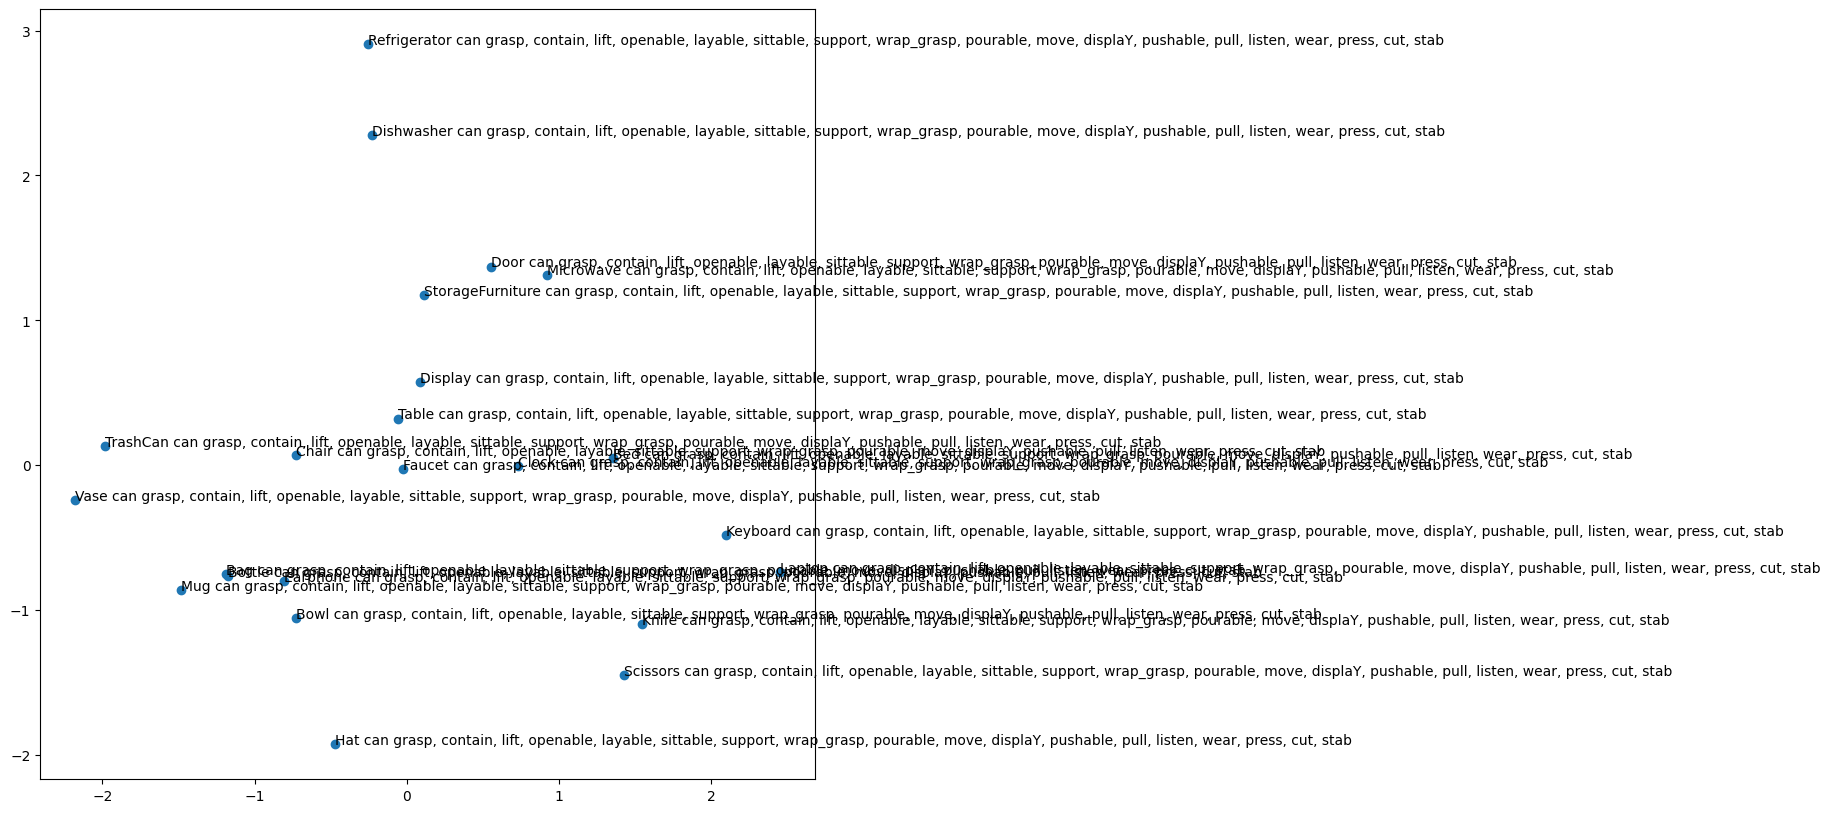

In [ ]:
# plot them and visualize ?

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
for i, text in enumerate(texts):
    plt.annotate(text, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.show()


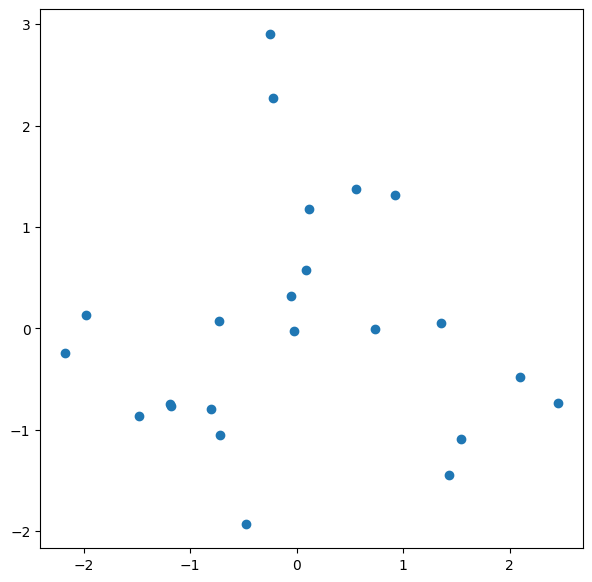

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from adjustText import adjust_text

plt.figure(figsize=(7, 7))
texts = []
x = reduced_embeddings[:, 0]
y = reduced_embeddings[:, 1]

plt.scatter(x, y)

# store text annotations
for i, label in enumerate(texts):
    texts.append(plt.text(x[i], y[i], label, ha='right', va='top', fontsize=8, alpha=0.5))

# adjust text to minimize overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.show()


In [ ]:
# for a 3d plot

In [ ]:
# # 3D visualization
# pca = PCA(n_components=3)
# reduced_embeddings_3d = pca.fit_transform(embeddings_np)


In [ ]:
import plotly.graph_objs as go


# Generate a list of (object, affordance, description) tuples
object_affordance_description = [
    (obj, aff, f"{obj} can {aff}")
    for obj, affs in affordance_dict.items()
    for aff in affs
]

# Generate embeddings for each affordance description
affordance_embeddings = np.vstack([
    get_clip_embeddings([desc]).detach().numpy()
    for _, _, desc in object_affordance_description
])

# Apply PCA to reduce to 3D
pca = PCA(n_components=3)
reduced_embeddings_3d = pca.fit_transform(affordance_embeddings)

# Prepare hover text with object names and affordances
hover_text = [f'{obj}<br>({aff})' for obj, aff, _ in object_affordance_description]

# Create traces for the Plotly plot, one for each affordance
traces = [
    go.Scatter3d(
        x=[embedding[0]],
        y=[embedding[1]],
        z=[embedding[2]],
        mode='markers+text',
        marker=dict(
            size=5,
            opacity=0.8
        ),
        text=[hover_text[i]],
        hoverinfo='text'
    )
    for i, embedding in enumerate(reduced_embeddings_3d)
]

# Configure the layout
layout = go.Layout(
    title='3D Plot of Objects with Affordances',
    scene=dict(
        xaxis=dict(title='PC1'),
        yaxis=dict(title='PC2'),
        zaxis=dict(title='PC3'),
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()


# Second approach I will create embeddings in a different fashion. In this approach I will plot SAME affordances AGAINST different objects and try to find their corelation

I'll use TSNE in this case instead of PCA

In [ ]:
!pip install git+https://github.com/openai/CLIP


In [ ]:
import clip
import torch
from sklearn.manifold import TSNE
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:15<00:00, 22.4MiB/s]


In [ ]:
def get_text_embeddings(affordances, model, device):
    with torch.no_grad():
        text_inputs = clip.tokenize(affordances).to(device)
        text_features = model.encode_text(text_inputs)
        return text_features.cpu().numpy()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 414 samples in 0.001s...
[t-SNE] Computed neighbors for 414 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 414 / 414
[t-SNE] Mean sigma: 2.387600
[t-SNE] KL divergence after 100 iterations with early exaggeration: 60.642689
[t-SNE] KL divergence after 300 iterations: 0.585981


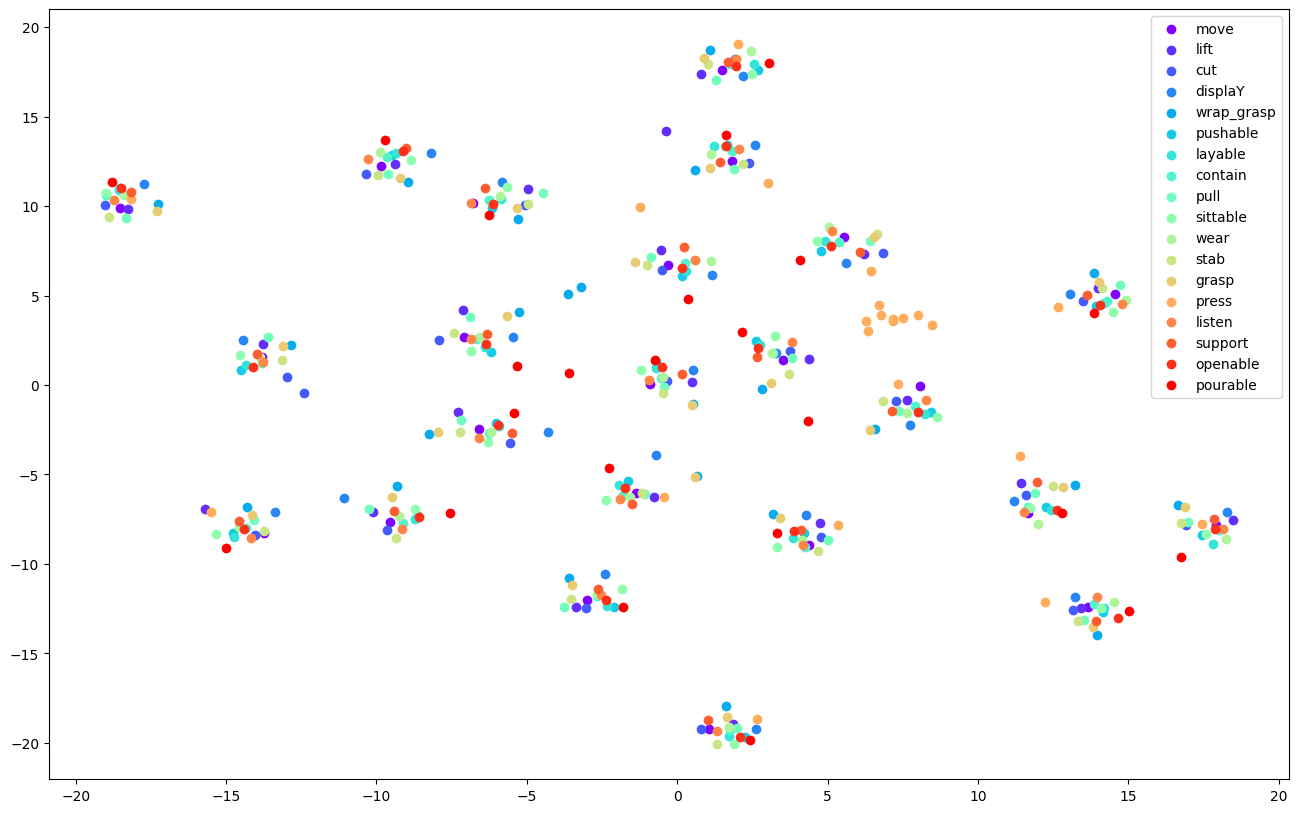

In [ ]:
# 1. Generate Embeddings for Object-Affordance Pairs

object_affordance_pairs = [(item['semantic class'] + ' ' + affordance) for item in data for affordance in item['affordance']]
unique_pairs = list(set(object_affordance_pairs))  # Removing duplicates
pair_embeddings = get_text_embeddings(unique_pairs, model, device)

# 2.Map Embeddings to Affordances
affordance_to_embeddings = {}
for pair, embedding in zip(unique_pairs, pair_embeddings):
    _, affordance = pair.split(' ', 1)
    if affordance not in affordance_to_embeddings:
        affordance_to_embeddings[affordance] = []
    affordance_to_embeddings[affordance].append(embedding)

# Step 3: Dimensionality Reduction
# I will flatten the list of embeddings and also at the same time  will remember the order of affordances for coloring
flattened_embeddings = []
affordance_order = []
for affordance, emb_list in affordance_to_embeddings.items():
    flattened_embeddings.extend(emb_list)
    affordance_order.extend([affordance] * len(emb_list))

# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(np.array(flattened_embeddings))

# Step 4: Visualization
plt.figure(figsize=(16, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, len(affordance_to_embeddings)))
for idx, affordance in enumerate(affordance_to_embeddings):
    indices = [i for i, x in enumerate(affordance_order) if x == affordance]
    current_tsne_results = tsne_results[indices, :]
    plt.scatter(current_tsne_results[:, 0], current_tsne_results[:, 1], c=[colors[idx]], label=affordance)

plt.legend()
plt.show()
